# Optical Flow Temporal Analysis

Modifica i parametri nella cella *Parameters* e poi esegui le singole celle per ottenere i plot inline.

In [1]:
# %%
# Environment & imports
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from typing import List, Tuple, Optional


## Parameters

In [2]:
# %%
# Paths & parameters
ROOT = Path.home() / 'Scrivania' / 'CorsoRepo' / 'cellPIV'
TEMPORAL_DIR = ROOT / '_02_temporalData' / 'final_series_csv'
DATA_TYPE = 'sum_mean_mag'            # sum_mean_mag / mean_magnitude / vorticity
OF_METHOD = 'Farneback'               # Farneback / Lucas-Kanade etc.
START_SHIFT = 0
END_FRAME = 128
TEST_METHOD = 'mannwhitney'           # 'mannwhitney' or 'ttest'
CORRECTION_METHOD = 'fdr_bh'          # 'fdr_bh' / 'bonferroni'
SAVE_PLOTS = False                    # True to save figures to OUTPUT_DIR
OUTPUT_DIR = ROOT / '_02_temporalData' / 'final_series_csv' / 'output_plots' / DATA_TYPE
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

TEMPORAL_DATA_PATH = TEMPORAL_DIR / f'{DATA_TYPE}_{OF_METHOD}.csv'
ORIGINAL_DB_PATH = ROOT / 'datasets' / 'DB_Morpheus_withID.csv'

print('Temporal data path:', TEMPORAL_DATA_PATH)
print('Original DB path:', ORIGINAL_DB_PATH)
print('Output dir:', OUTPUT_DIR)


Temporal data path: /home/phd2/Scrivania/CorsoRepo/cellPIV/_02_temporalData/final_series_csv/sum_mean_mag_Farneback.csv
Original DB path: /home/phd2/Scrivania/CorsoRepo/cellPIV/datasets/DB_Morpheus_withID.csv
Output dir: /home/phd2/Scrivania/CorsoRepo/cellPIV/_02_temporalData/final_series_csv/output_plots/sum_mean_mag


## Helper functions

In [3]:
# %%
def import_original_db_and_merge_data(data: pd.DataFrame, original_db_path: Path, remove_not_vitals: bool=False) -> pd.DataFrame:
    db_cols = ['dish_well', 'BLASTO NY', 'PN']
    df_db = pd.read_csv(original_db_path)[db_cols]
    merged = pd.merge(data, df_db, on='dish_well', how='left')
    if remove_not_vitals:
        merged = merged.loc[~merged['PN'].isin(['0PN', 'deg'])]
    return merged


def separate_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return df[df['BLASTO NY'] == 1].copy(), df[df['BLASTO NY'] == 0].copy()


def get_time_cols(df: pd.DataFrame) -> List[str]:
    return [c for c in df.columns if c.startswith('time_')]


def statistical_tests_with_correction(df1: pd.DataFrame, df2: pd.DataFrame, cols: List[str], alpha: float=0.05,
                                      method: str='fdr_bh', test_type: str='mannwhitney'):
    pvals = []
    for c in cols:
        x1, x2 = df1[c].dropna(), df2[c].dropna()
        if len(x1) < 2 or len(x2) < 2:
            pvals.append(1.0)
            continue
        if test_type == 'mannwhitney':
            _, p = mannwhitneyu(x1, x2, alternative='two-sided')
        else:
            _, p = ttest_ind(x1, x2, equal_var=False)
        pvals.append(float(p))
    reject, p_corr, _, _ = multipletests(pvals, alpha=alpha, method=method)
    idxs = np.where(reject)[0]
    intervals = []
    if idxs.size:
        start = idxs[0]
        for i in range(1, len(idxs)):
            if idxs[i] != idxs[i-1] + 1:
                intervals.append((start, idxs[i-1]))
                start = idxs[i]
        intervals.append((start, idxs[-1]))
    return pvals, p_corr.tolist(), reject.tolist(), intervals


def plot_stratified(df: pd.DataFrame, title: str, ylim: Optional[Tuple[float,float]]=None) -> plt.Figure:
    cols = get_time_cols(df)
    x = np.arange(len(cols))
    pn_labels = sorted(df['PN'].dropna().unique())
    fig, ax = plt.subplots(figsize=(8,4))
    for pn in pn_labels:
        sub = df[df['PN'] == pn]
        if sub.empty:
            continue
        m, s = sub[cols].mean(), sub[cols].std()
        ax.plot(x, m, label=str(pn))
        ax.fill_between(x, m - s, m + s, alpha=0.1)
    ax.set_title(title, pad=12)
    ax.set_xlabel('Frame')
    ax.set_ylabel('Optical Flow Metric')
    ax.grid(True)
    ax.legend(fontsize=8)
    if ylim is not None:
        ax.set_ylim(*ylim)
    fig.tight_layout()
    return fig


def plot_with_significance(df_bl: pd.DataFrame, df_nb: pd.DataFrame, cols: List[str], intervals: List[Tuple[int,int]],
                           label1: str, label2: str, title: Optional[str]=None, ylim: Optional[Tuple[float,float]]=None) -> plt.Figure:
    x = np.arange(len(cols))
    m1, s1 = df_bl[cols].mean(), df_bl[cols].std()
    m2, s2 = df_nb[cols].mean(), df_nb[cols].std()
    fig, ax = plt.subplots(figsize=(8,4))

    # Plot mean +- std
    ax.plot(x, m1, label=label1)
    ax.fill_between(x, m1 - s1, m1 + s1, alpha=0.1)
    ax.plot(x, m2, label=label2)
    ax.fill_between(x, m2 - s2, m2 + s2, alpha=0.1)

    # Shade significance intervals
    if intervals:
        ymin, ymax = ax.get_ylim()
        y_offset = (ymax - ymin) * 0.02
        y_pos_start = ymax - y_offset
        y_pos_end = ymax - 2*y_offset
        for i, (s_i, e_i) in enumerate(intervals):
            ax.axvspan(s_i, e_i, color='orange', alpha=0.2)
            ax.axvline(s_i, color='lightgrey', linestyle='dotted')
            ax.axvline(e_i, color='lightgrey', linestyle='dotted')
            ax.text((s_i+e_i)/2, y_pos_start - i*y_offset, f'{s_i}-{e_i}', ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Frame')
    ax.set_ylabel('Optical Flow Metric')
    ax.grid(True)
    ax.legend()
    if title:
        ax.set_title(title, pad=12)
    if ylim is not None:
        ax.set_ylim(*ylim)
    fig.tight_layout()
    return fig


def mean_std_x_calc(df_ref: pd.DataFrame, cols_all: List[str]):
    ref_mean = df_ref[cols_all].mean().values
    ref_std = df_ref[cols_all].std().values
    x = np.arange(len(cols_all))
    return ref_mean, ref_std, x


## Load data

In [4]:
# %%
# Load temporal CSV and merge with DB
if not TEMPORAL_DATA_PATH.exists():
    raise FileNotFoundError(f"Temporal data file not found: {TEMPORAL_DATA_PATH}")

_df_temp = pd.read_csv(TEMPORAL_DATA_PATH)
_df_full = import_original_db_and_merge_data(_df_temp, ORIGINAL_DB_PATH, remove_not_vitals=False)
# remove '0PN' and 'deg' from full set for downstream analyses
_df_clean = _df_full.loc[~_df_full['PN'].isin(['0PN', 'deg'])].copy()
blasto_df, no_blasto_df = separate_data(_df_clean)
cols_all = get_time_cols(_df_clean)[START_SHIFT:END_FRAME]
print('Loaded data with shapes:', _df_temp.shape, _df_full.shape, _df_clean.shape)


Loaded data with shapes: (6047, 673) (6048, 675) (5047, 675)


## 1) Stratified plots per gruppo (esegui la cella per ciascun valore di zoom)

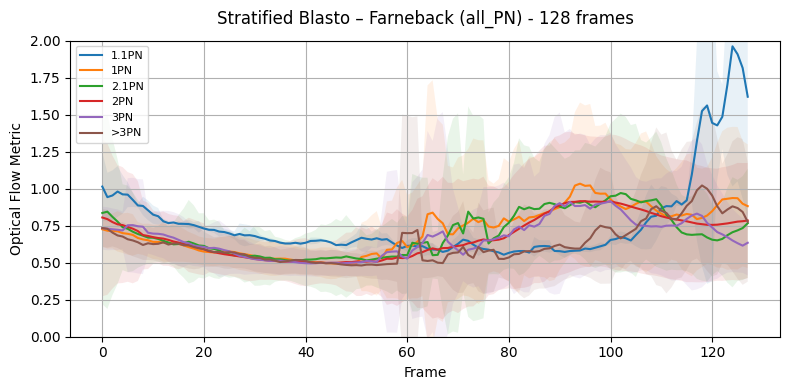

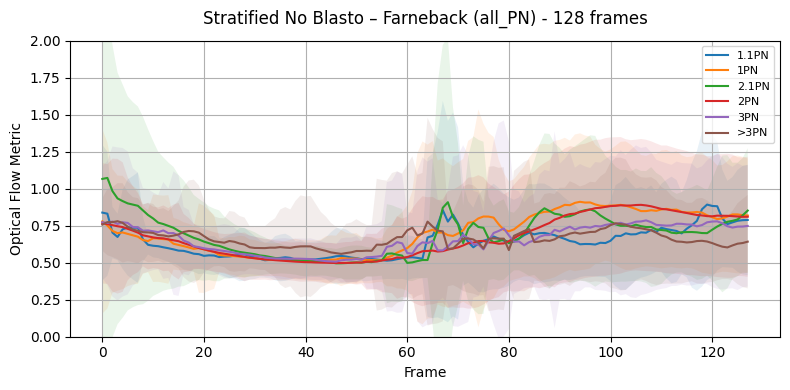

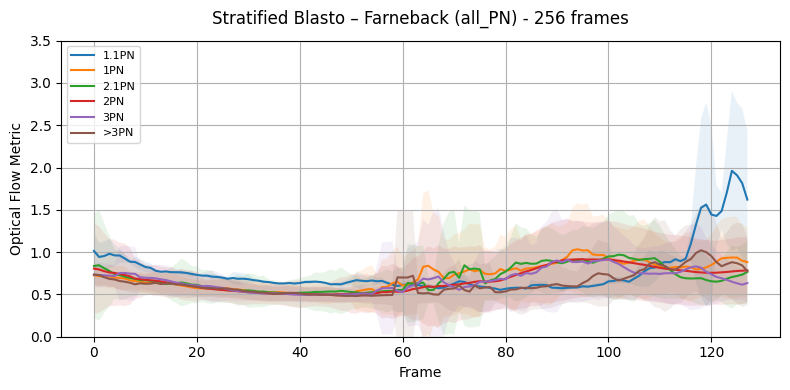

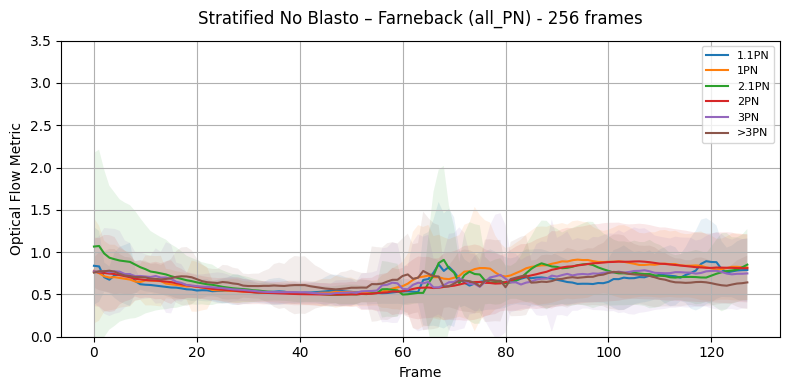

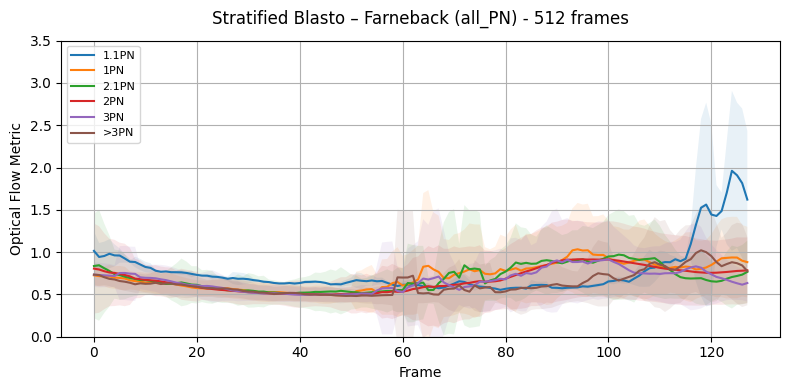

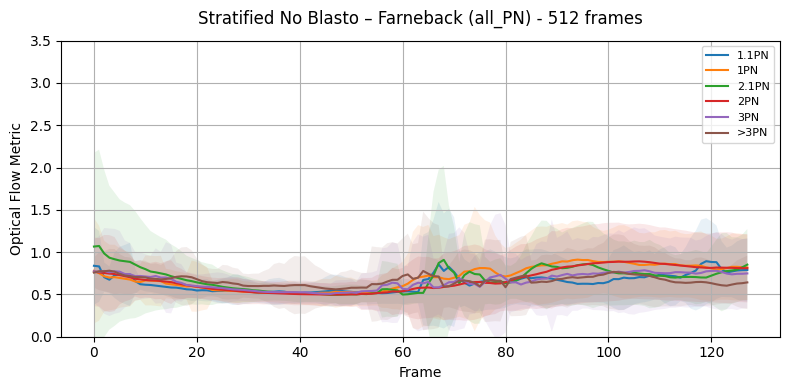

In [5]:
# %%
# Example: genera i plot stratificati per alcuni zoom levels
different_zoom = [128, 256, 512]
for max_frame in different_zoom:
    cols_to_consider = cols_all[:max_frame]
    ylim = (0, 3.5) if DATA_TYPE != 'vorticity' and max_frame>150 else ((0,2) if DATA_TYPE!='vorticity' else (-0.005,0.005))

    fig_bl = plot_stratified(blasto_df[['dish_well','PN','BLASTO NY'] + cols_to_consider],
                             f'Stratified Blasto – {OF_METHOD} (all_PN) - {max_frame} frames', ylim=ylim)
    fig_nb = plot_stratified(no_blasto_df[['dish_well','PN','BLASTO NY'] + cols_to_consider],
                             f'Stratified No Blasto – {OF_METHOD} (all_PN) - {max_frame} frames', ylim=ylim)
    display(fig_bl)
    display(fig_nb)
    if SAVE_PLOTS:
        fig_bl.savefig(OUTPUT_DIR / f'stratified_all_PN_blasto_{max_frame}frames.png', dpi=150)
        fig_nb.savefig(OUTPUT_DIR / f'stratified_all_PN_noblasto_{max_frame}frames.png', dpi=150)
    plt.close(fig_bl)
    plt.close(fig_nb)


## 2) Pairwise comparisons: 2PN vs altri (Blasto / NoBlasto / cross)

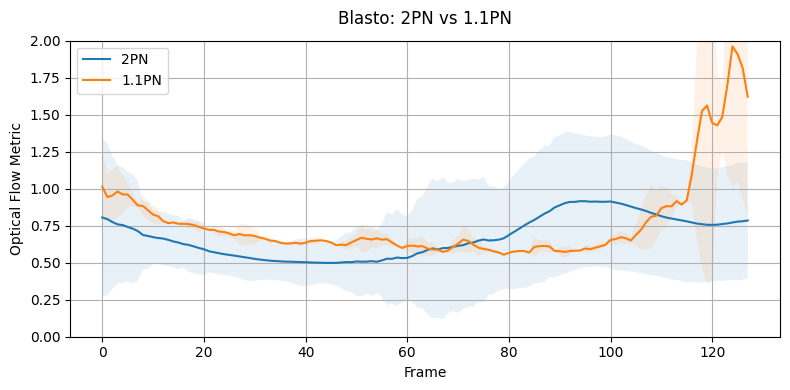

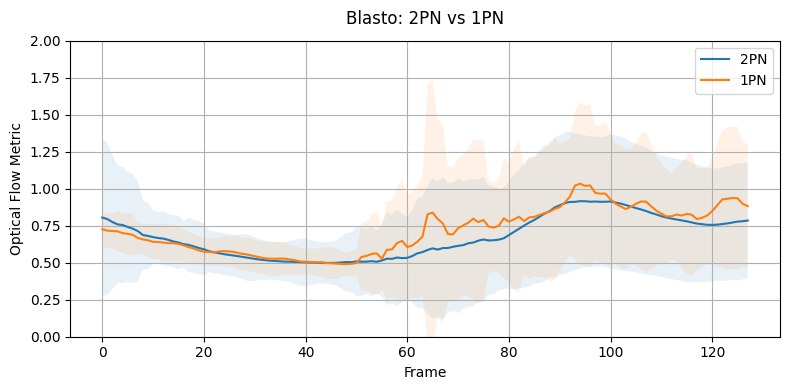

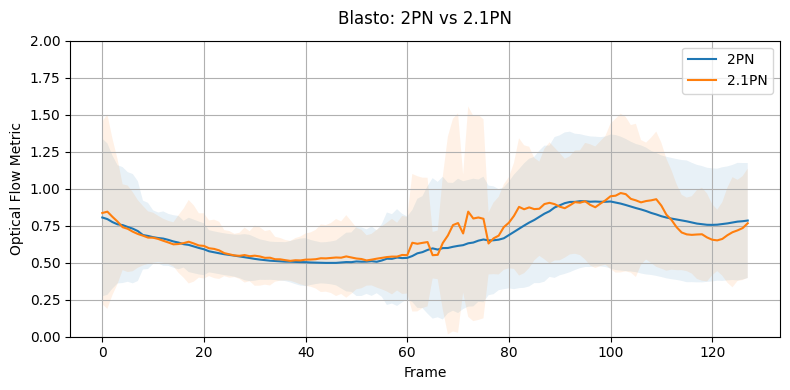

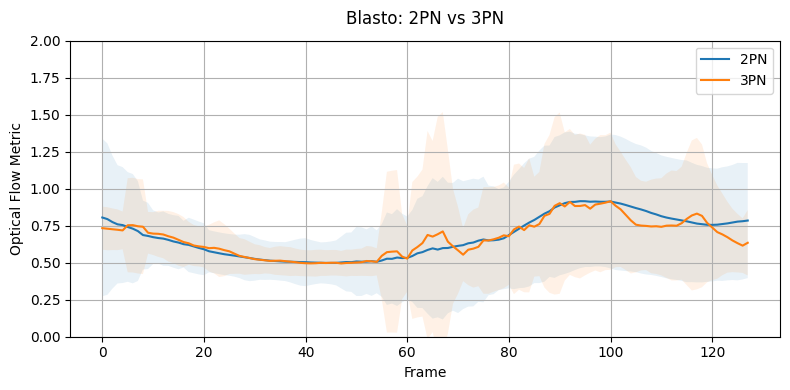

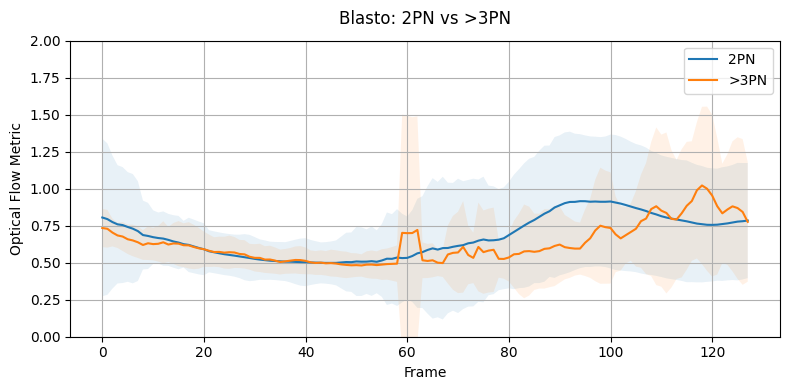

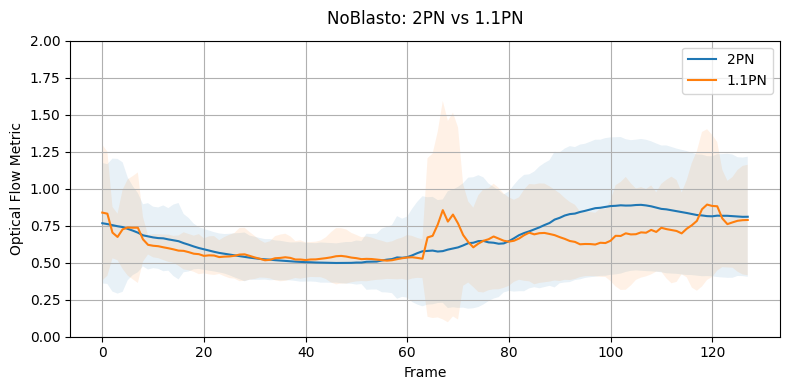

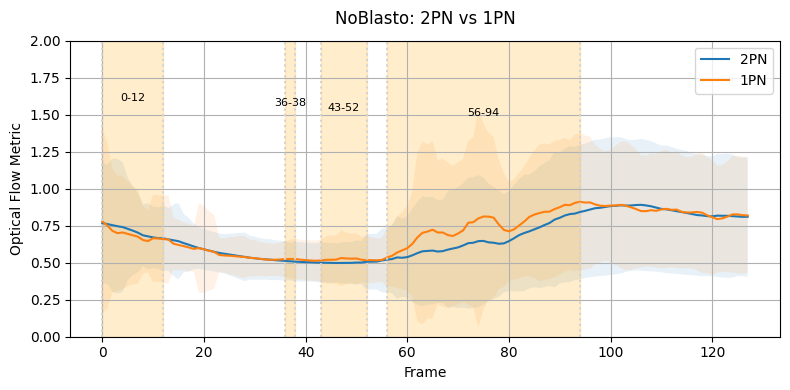

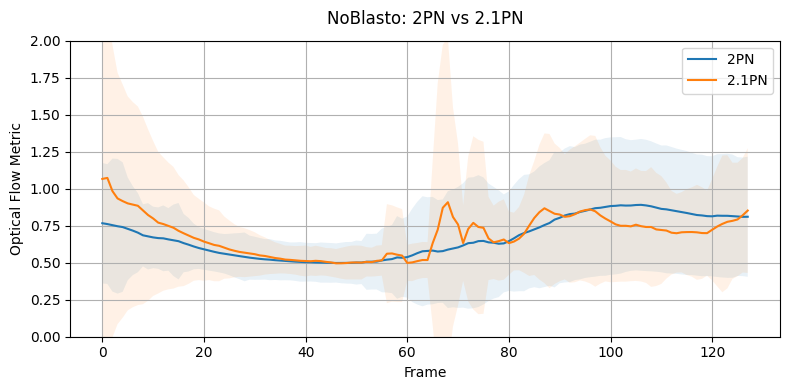

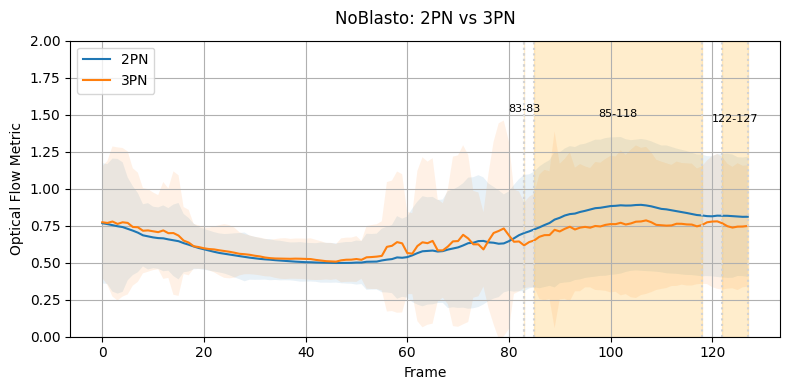

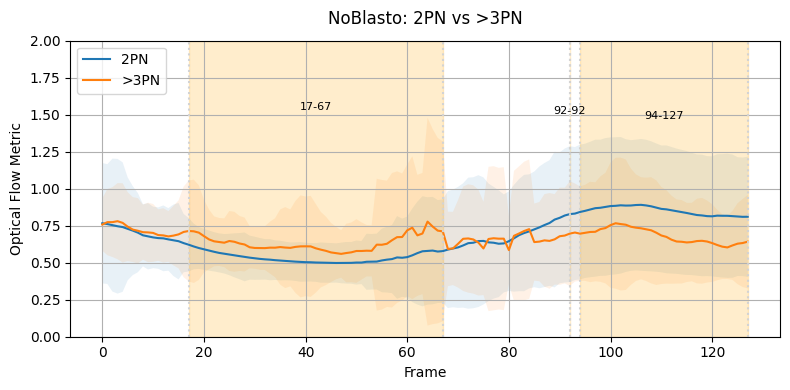

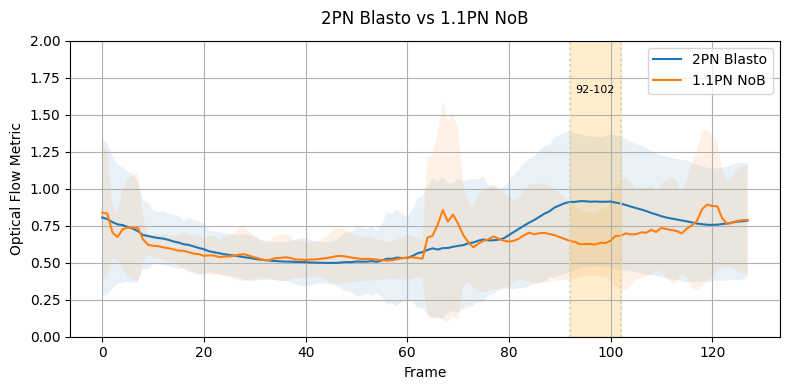

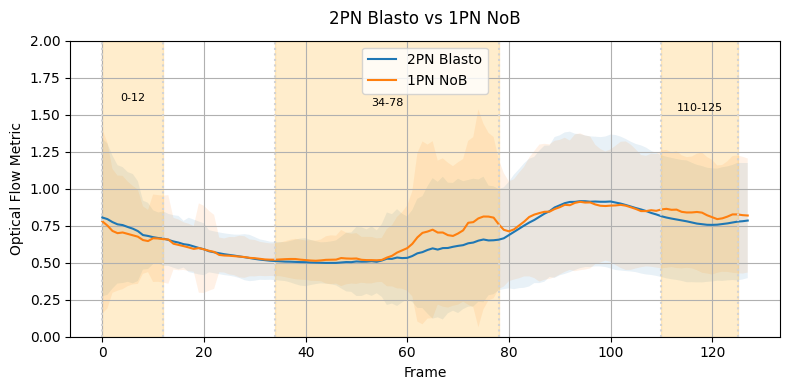

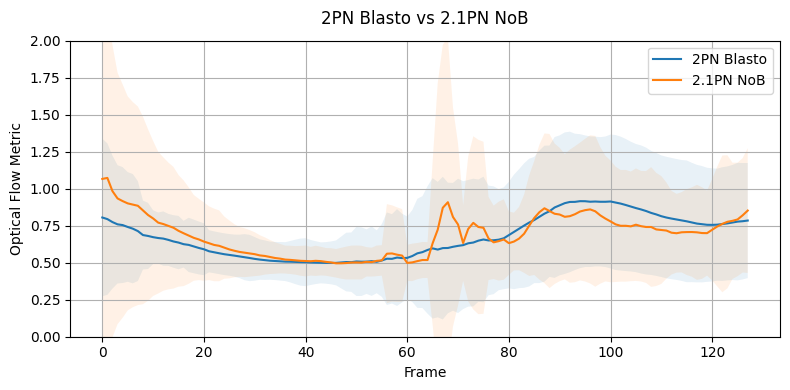

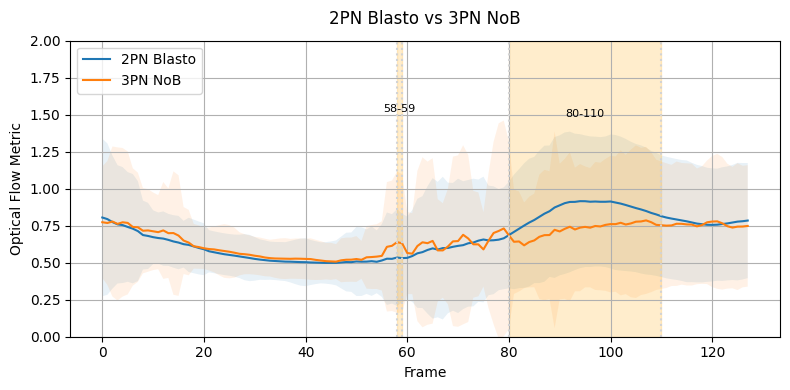

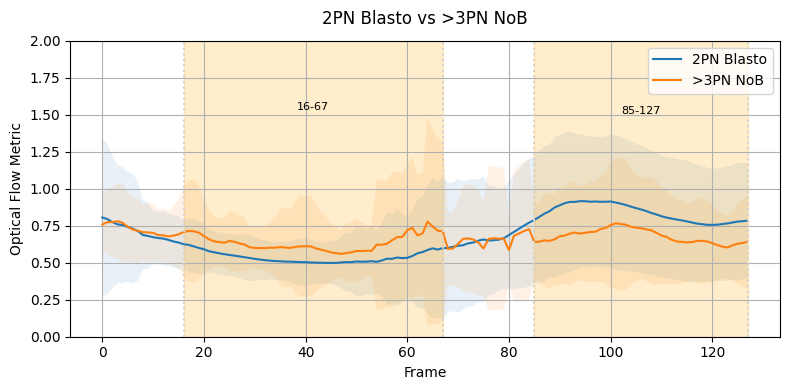

In [6]:
# %%
# 2PN vs others (Blasto)
target = '2PN'
others = [pn for pn in sorted(blasto_df['PN'].dropna().unique()) if pn != target]
figs = []
for other in others:
    df1 = blasto_df[blasto_df['PN'] == target]
    df2 = blasto_df[blasto_df['PN'] == other]
    pvals, p_corr, reject, intervals = statistical_tests_with_correction(df1[cols_all], df2[cols_all], cols_all,
                                                                          alpha=0.05, method=CORRECTION_METHOD, test_type=TEST_METHOD)
    fig = plot_with_significance(df1, df2, cols_all, intervals, f'{target}', f'{other}', title=f'Blasto: {target} vs {other}',
                                 ylim=(0,2) if DATA_TYPE!='vorticity' else (-0.005,0.005))
    display(fig)
    if SAVE_PLOTS:
        fig.savefig(OUTPUT_DIR / f'pairwise_2PN_blasto_{other}.png', dpi=150)
    plt.close(fig)

# 2PN vs others (NoBlasto)
others_nb = [pn for pn in sorted(no_blasto_df['PN'].dropna().unique()) if pn != target]
for other in others_nb:
    df1 = no_blasto_df[no_blasto_df['PN'] == target]
    df2 = no_blasto_df[no_blasto_df['PN'] == other]
    pvals, p_corr, reject, intervals = statistical_tests_with_correction(df1[cols_all], df2[cols_all], cols_all,
                                                                          alpha=0.05, method=CORRECTION_METHOD, test_type=TEST_METHOD)
    fig = plot_with_significance(df1, df2, cols_all, intervals, f'{target}', f'{other}', title=f'NoBlasto: {target} vs {other}',
                                 ylim=(0,2) if DATA_TYPE!='vorticity' else (-0.005,0.005))
    display(fig)
    if SAVE_PLOTS:
        fig.savefig(OUTPUT_DIR / f'pairwise_2PN_noblasto_{other}.png', dpi=150)
    plt.close(fig)

# 2PN Blasto vs other NoBlasto (cross)
for other in others_nb:
    df_bl2pn = blasto_df[blasto_df['PN'] == target]
    df_nbX = no_blasto_df[no_blasto_df['PN'] == other]
    _, _, _, intervals = statistical_tests_with_correction(df_bl2pn[cols_all], df_nbX[cols_all], cols_all,
                                                           alpha=0.05, method=CORRECTION_METHOD, test_type=TEST_METHOD)
    fig = plot_with_significance(df_bl2pn, df_nbX, cols_all, intervals, '2PN Blasto', f'{other} NoB',
                                 title=f'2PN Blasto vs {other} NoB', ylim=(0,2) if DATA_TYPE!='vorticity' else (-0.005,0.005))
    display(fig)
    if SAVE_PLOTS:
        fig.savefig(OUTPUT_DIR / f'pairwise_2PN_bl_vs_nb_{other}.png', dpi=150)
    plt.close(fig)


## 3) Blasto vs NoBlasto per PN (subplot per tipo PN)

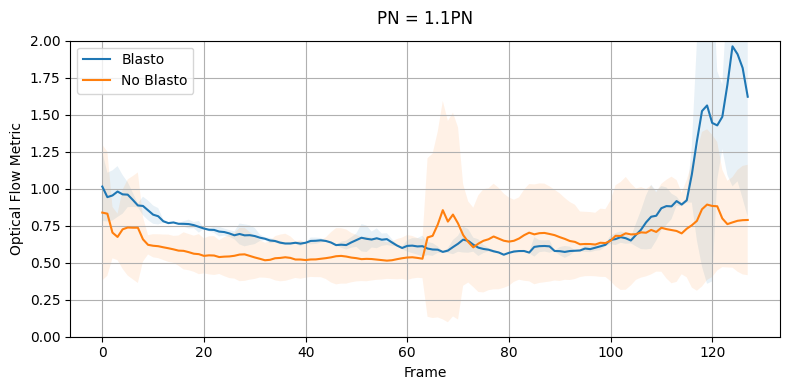

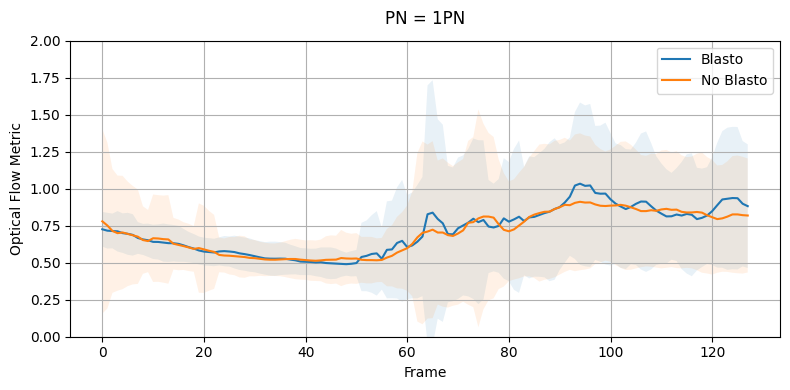

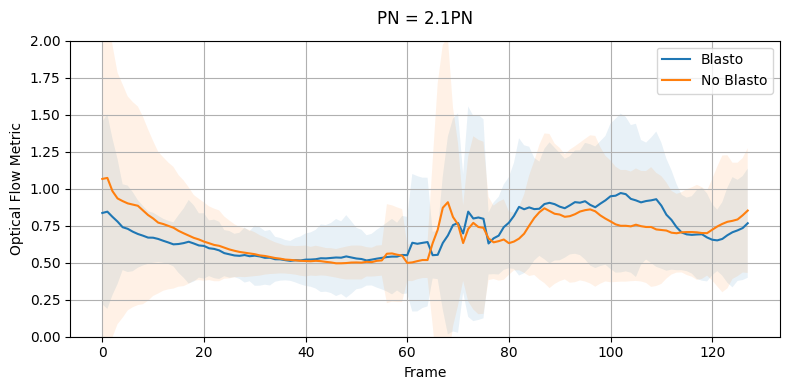

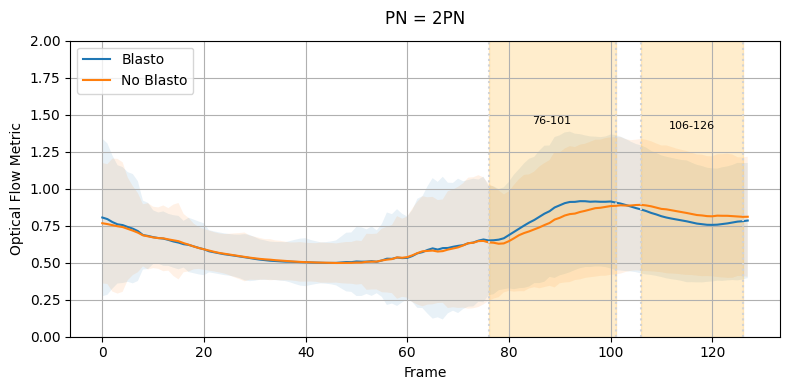

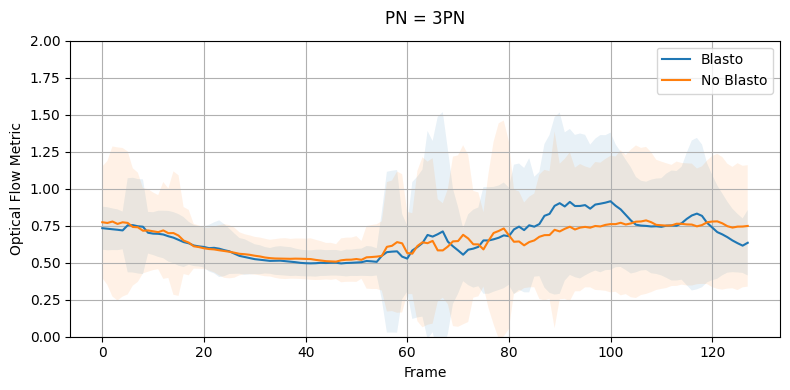

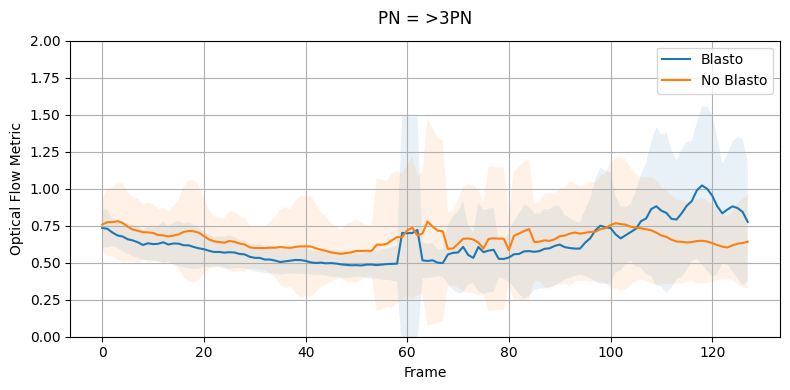

In [7]:
# %%
pn_types = sorted(_df_clean['PN'].dropna().unique())
fig, axes = plt.subplots(1, len(pn_types), figsize=(5*len(pn_types), 4), sharey=True)
if len(pn_types) == 1:
    axes = [axes]

for ax, pn in zip(axes, pn_types):
    df_pn = _df_clean[_df_clean['PN'] == pn]
    df_b, df_nb = separate_data(df_pn)
    pvals, p_corr, reject, intervals = statistical_tests_with_correction(df_b[cols_all], df_nb[cols_all], cols_all,
                                                                          alpha=0.05, method=CORRECTION_METHOD, test_type=TEST_METHOD)
    # Show individual plot
    fig_local = plot_with_significance(df_b, df_nb, cols_all, intervals, 'Blasto', 'No Blasto', title=f'PN = {pn}',
                                       ylim=(0,2) if DATA_TYPE!='vorticity' else (-0.005,0.005))
    # copy artists onto main axes is not trivial — instead display separately
    display(fig_local)
    plt.close(fig_local)

fig.tight_layout()
if SAVE_PLOTS:
    fig.savefig(OUTPUT_DIR / 'blasto_vs_noblasto_per_PN.png', dpi=150)
plt.close(fig)


## Analisi 1: Similarity-based subgroups rispetto a 2PN-blasto

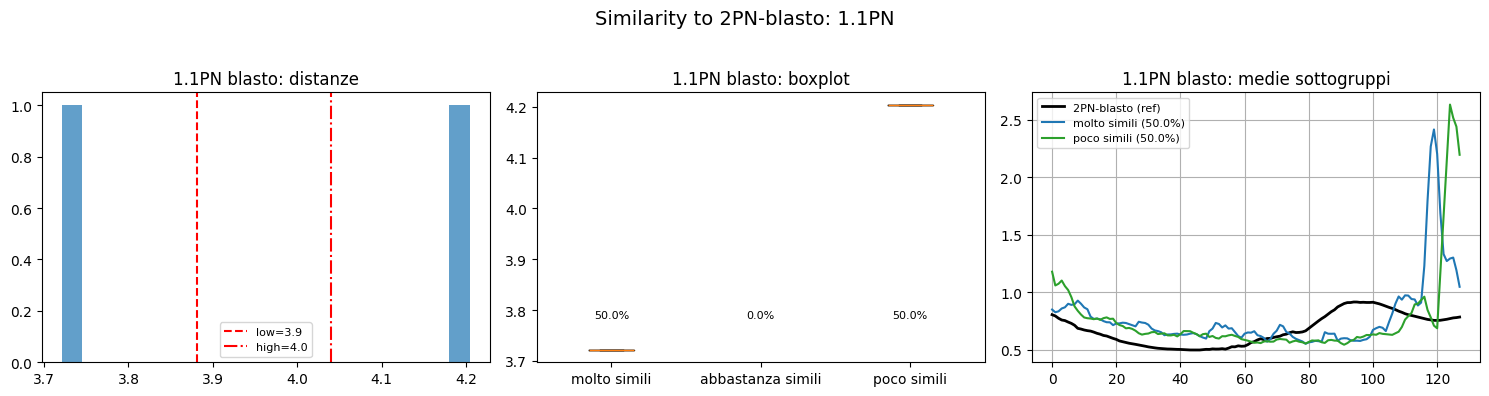

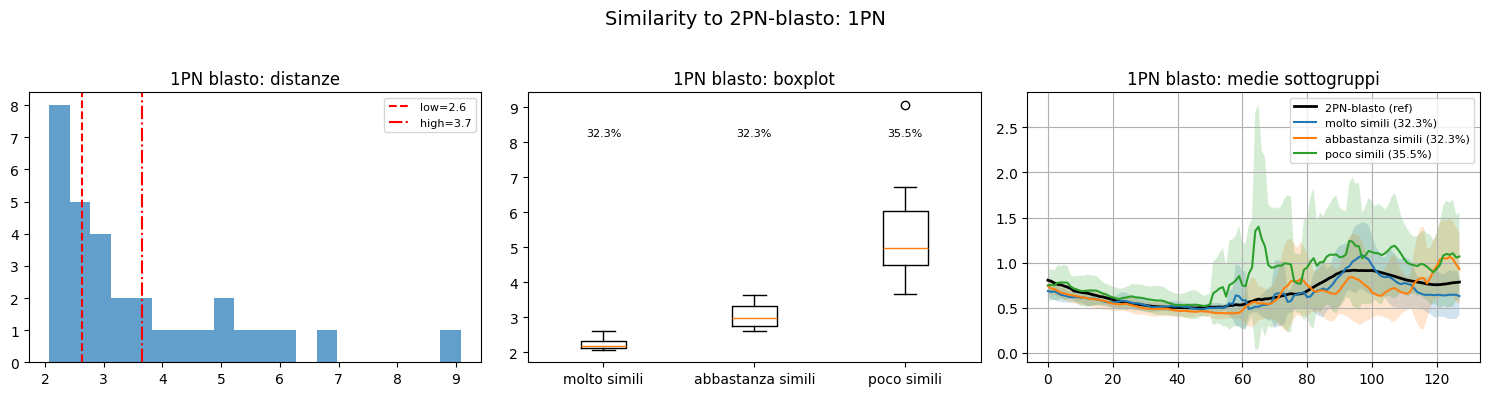

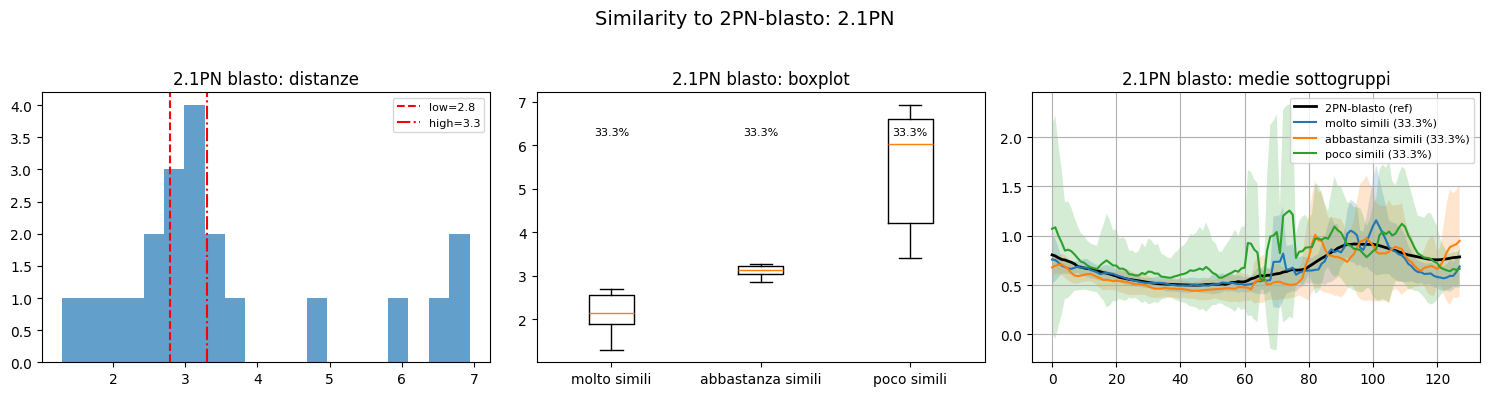

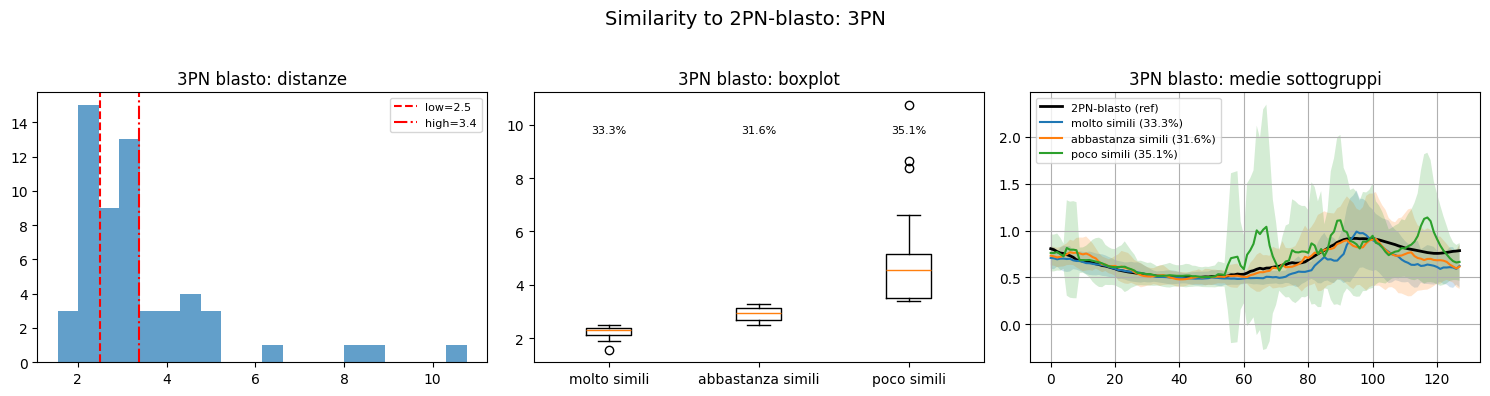

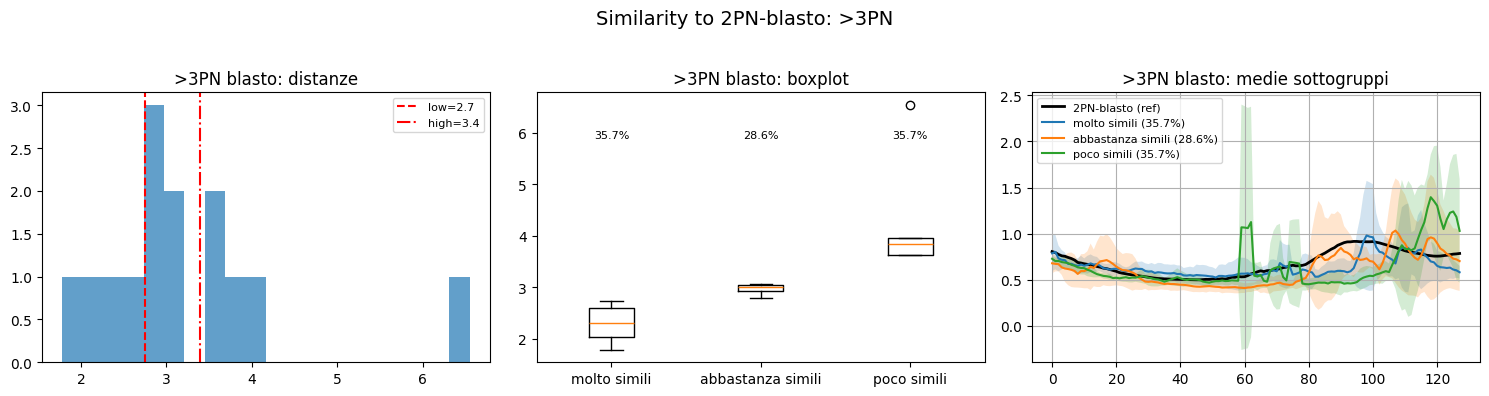

In [10]:
# %%
# Curva di riferimento
_df_ref = blasto_df[blasto_df['PN'] == '2PN']
ref_mean, ref_std, x = mean_std_x_calc(df_ref=_df_ref, cols_all=cols_all)

anomalous_pns = [pn for pn in sorted(blasto_df['PN'].dropna().unique()) if pn != '2PN']

for pn in anomalous_pns:
    df_anomal = blasto_df[blasto_df['PN'] == pn].copy()
    if df_anomal.empty:
        continue
    distances = df_anomal[cols_all].apply(lambda row: np.linalg.norm(row.values - ref_mean), axis=1).values
    thr_low, thr_high = np.percentile(distances, [33, 66])
    cats = np.digitize(distances, bins=[thr_low, thr_high])
    df_anomal['distance'] = distances
    df_anomal['cat'] = cats
    pct = [(cats == k).mean()*100 for k in [0,1,2]]

    # hist
    fig, axes = plt.subplots(1,3, figsize=(15,4))
    axes[0].hist(distances, bins=20, alpha=0.7)
    axes[0].axvline(thr_low, color='red', linestyle='--', label=f'low={thr_low:.1f}')
    axes[0].axvline(thr_high, color='red', linestyle='-.', label=f'high={thr_high:.1f}')
    axes[0].set_title(f'{pn} blasto: distanze')
    axes[0].legend(fontsize=8)

    # box
    labels = ['molto simili','abbastanza simili','poco simili']
    data_for_box = [distances[cats==k] for k in [0,1,2]]
    axes[1].boxplot(data_for_box, tick_labels=labels)
    axes[1].set_title(f'{pn} blasto: boxplot')
    for k, p in enumerate(pct):
        axes[1].text(k+1, np.max(distances)*0.9 if len(distances)>0 else 0, f'{p:.1f}%', ha='center', fontsize=8)

    # mean series per category
    axes[2].plot(x, ref_mean, label='2PN-blasto (ref)', color='black', linewidth=2)
    colors = ['C0','C1','C2']
    for k in [0,1,2]:
        grp = df_anomal[df_anomal['cat']==k]
        if len(grp):
            m = grp[cols_all].mean()
            s = grp[cols_all].std()
            axes[2].plot(x, m, label=f'{labels[k]} ({pct[k]:.1f}%)', color=colors[k])
            axes[2].fill_between(x, m-s, m+s, alpha=0.2)
    axes[2].set_title(f'{pn} blasto: medie sottogruppi')
    axes[2].grid(True)
    axes[2].legend(fontsize=8)

    fig.suptitle(f'Similarity to 2PN-blasto: {pn}', fontsize=14)
    fig.tight_layout(rect=[0,0,1,0.95])
    display(fig)
    if SAVE_PLOTS:
        fig.savefig(OUTPUT_DIR / f'anomalous_similarity_{pn}.png', dpi=150)
    plt.close(fig)


## Analisi 2: Categorizzazione basata su deviazione standard (RMS-z)

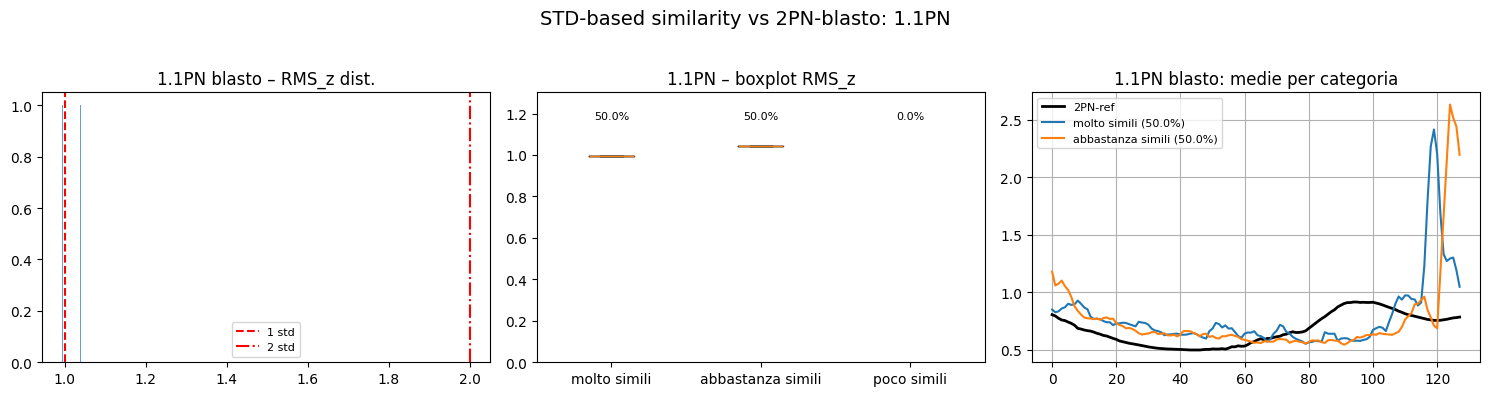

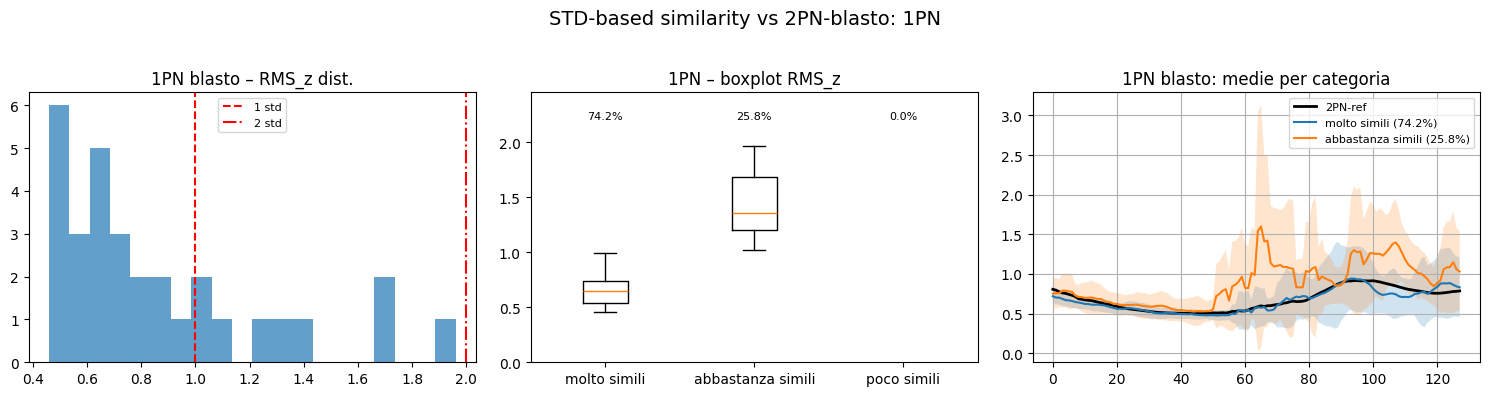

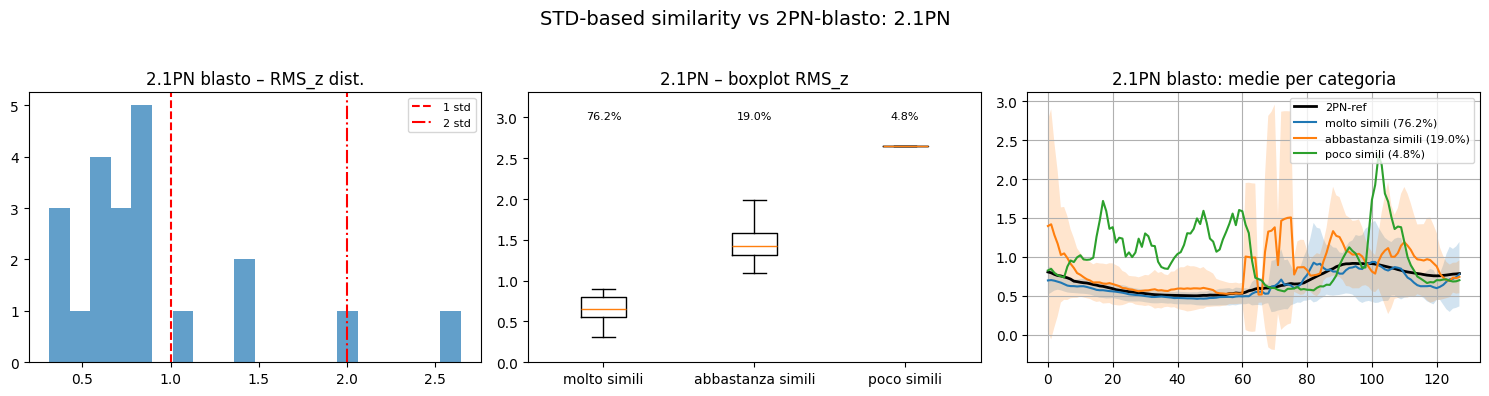

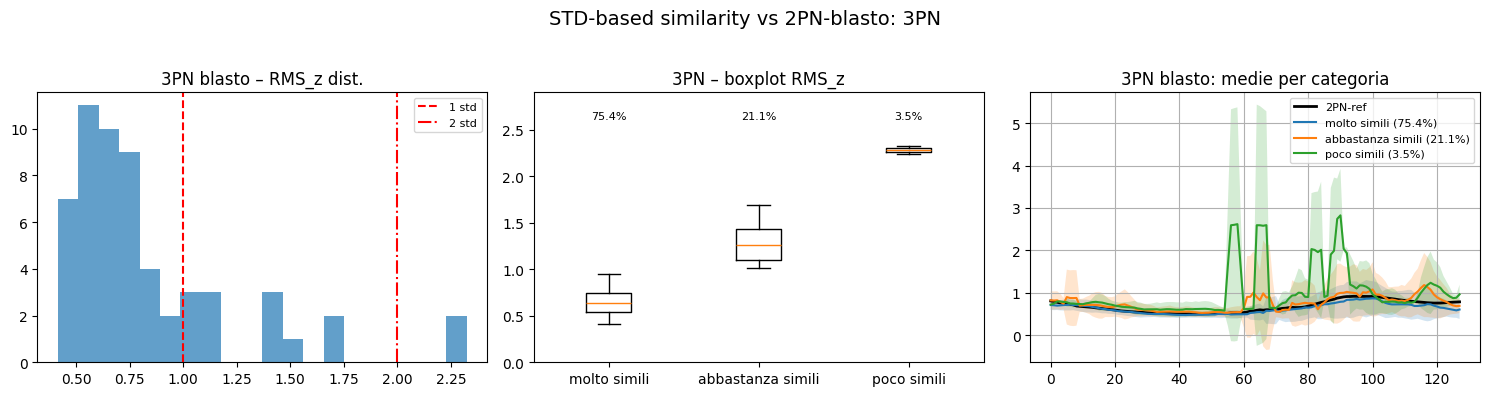

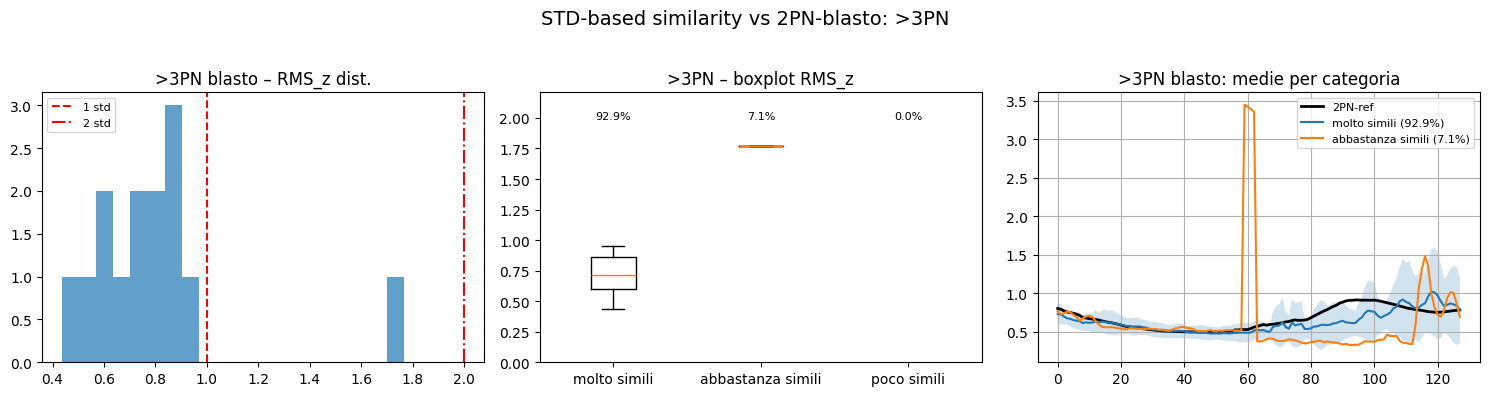

Notebook cells complete.


In [15]:
# %%
for pn in anomalous_pns:
    df_ano = blasto_df[blasto_df['PN'] == pn].copy()
    if df_ano.empty:
        continue
    def rms_z(row):
        z = (row.values - ref_mean) / ref_std
        return np.sqrt(np.nanmean(z**2))
    RMS_z = df_ano[cols_all].apply(rms_z, axis=1).values
    bins = [1.0, 2.0]
    labels = ['molto simili','abbastanza simili','poco simili']
    cats = np.digitize(RMS_z, bins=bins)
    df_ano['RMS_z'] = RMS_z
    df_ano['cat']   = cats
    pct = [(cats == k).mean()*100 for k in [0,1,2]]

    fig, axes = plt.subplots(1,3, figsize=(15,4))
    # hist
    counts, bins_out, _ = axes[0].hist(RMS_z, bins=20, alpha=0.7)
    axes[0].axvline(1, color='red', linestyle='--', label='1 std')
    axes[0].axvline(2, color='red', linestyle='-.', label='2 std')
    axes[0].set_title(f'{pn} blasto – RMS_z dist.')
    axes[0].legend(fontsize=8)

    # box
    data_box = [RMS_z[cats==k] for k in [0,1,2]]
    axes[1].boxplot(data_box, tick_labels=labels)
    axes[1].set_title(f'{pn} – boxplot RMS_z')
    ymax = np.nanmax(RMS_z) * 1.25 if len(RMS_z)>0 else 1
    axes[1].set_ylim(0, ymax)
    for k,p in enumerate(pct):
        axes[1].text(k+1, ymax*0.9, f'{p:.1f}%', ha='center', fontsize=8)

    # series
    axes[2].plot(x, ref_mean, color='black', lw=2, label='2PN-ref')
    for k in [0,1,2]:
        grp = df_ano[df_ano['cat']==k]
        if len(grp):
            m = grp[cols_all].mean()
            s = grp[cols_all].std()
            axes[2].plot(x, m, label=f'{labels[k]} ({pct[k]:.1f}%)')
            axes[2].fill_between(x, m-s, m+s, alpha=0.2)
    axes[2].set_title(f'{pn} blasto: medie per categoria')
    axes[2].grid(True)
    axes[2].legend(fontsize=8)

    fig.suptitle(f'STD-based similarity vs 2PN-blasto: {pn}', fontsize=14)
    fig.tight_layout(rect=[0,0,1,0.95])
    display(fig)
    if SAVE_PLOTS:
        fig.savefig(OUTPUT_DIR / f'anomalous_std_similarity_{pn}.png', dpi=150)
    plt.close(fig)

print('Notebook cells complete.')
